In [264]:
data = ''
with open("./data/MLBOOK.txt", "r", encoding="utf8") as f:
    data = f.read()
f.close()
data = data.replace('\n',' ')
data[:500].strip()

'Introduction  Data comes in many shapes and forms, but can generally be thought of as being the result of some random experiment — an experiment whose outcome cannot be determined in advance, but whose workings are still subject to analysis. Data from a random experiment are often stored in a table or spreadsheet. A statistical convention is to denote variables — often called features — as columns and the individual items (or units) as rows. It is useful to think of three types of columns in suc'

In [265]:
words = list(set(data.split()))
vocab_size = len(words)
print(vocab_size)

27823


In [267]:
#Create a mapping for words to integers.

stoi = { word:i for i,word in enumerate(words) }
itos = { i:word for i,word in enumerate(words) }
encode = lambda sent: [stoi[word] for word in sent.split()]
decode = lambda l: ' '.join(itos[i] for i in l)

print(encode('Data science'))
print(decode(encode('Data science')))



[21048, 16945]
Data science


In [44]:
import torch

In [268]:
#Preparing data tensor
data_tensor = torch.tensor(encode(data))
#Splitting data into train and validation data
n = int(0.9*len(data))
train_data = data_tensor[:n]
val_data = data_tensor[n:]

In [269]:
context_length = 32
decode(train_data[:context_length].tolist())

'Introduction Data comes in many shapes and forms, but can generally be thought of as being the result of some random experiment — an experiment whose outcome cannot be determined in advance,'

In [270]:
type(train_data)

torch.Tensor

In [271]:
x = train_data[:context_length].tolist()
y = train_data[1:context_length+1].tolist()

for i in range(context_length):
    context = x[:i+1]
    target = y[i]
    print(f'Input: {context}, output: {target}')
    if i==7:
        break

Input: [26365], output: 21048
Input: [26365, 21048], output: 4763
Input: [26365, 21048, 4763], output: 22366
Input: [26365, 21048, 4763, 22366], output: 2323
Input: [26365, 21048, 4763, 22366, 2323], output: 26185
Input: [26365, 21048, 4763, 22366, 2323, 26185], output: 16333
Input: [26365, 21048, 4763, 22366, 2323, 26185, 16333], output: 27170
Input: [26365, 21048, 4763, 22366, 2323, 26185, 16333, 27170], output: 1823


In [272]:
#Making batches 

torch.manual_seed(596)
batch_size = 16
context_length = 64

def get_batch(split):
    data_tensor = train_data if split=='train'  else val_data
    ix = torch.randint(len(data_tensor)-context_length, (batch_size,))
    x = torch.stack([data_tensor[i:i+context_length] for i in ix])
    y = torch.stack([data_tensor[i+1:i+context_length+1] for i in ix])
    return x,y

xb, yb = get_batch('train')
print('inputs')
print(xb.shape)
print(xb)

print('Targets')
print(yb.shape)
print(yb)

inputs
torch.Size([16, 64])
tensor([[26361, 25169,  6244,  ..., 17521, 13916,  1006],
        [ 9030, 19767, 11768,  ..., 25307,  5194,  6281],
        [14464, 20187, 21533,  ..., 12920,   696,  4926],
        ...,
        [16751, 19229,  8974,  ..., 11475, 21457, 23212],
        [ 5194, 20015,  4108,  ..., 19674, 27506, 23396],
        [17828, 10162,  5098,  ..., 12489,  5811, 10874]])
Targets
torch.Size([16, 64])
tensor([[25169,  6244, 10383,  ..., 13916,  1006, 10354],
        [19767, 11768, 13527,  ...,  5194,  6281, 17758],
        [20187, 21533, 14145,  ...,   696,  4926, 21090],
        ...,
        [19229,  8974,  7142,  ..., 21457, 23212, 23638],
        [20015,  4108, 25996,  ..., 27506, 23396, 13120],
        [10162,  5098, 20549,  ...,  5811, 10874, 21370]])


In [340]:
a,b = torch.randn(16, 32, 256), torch.randn(16, 32, 256)
ab_cat = torch.cat([a, b], -1)
ab_cat.shape

torch.Size([16, 32, 512])

In [374]:
#Building the very basic bigram model
from torch.nn import functional as F
import torch.nn as nn
torch.manual_seed(596)

class PositionalEncoding(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super().__init__()
        self.embed_size = embed_size
        self.embed = nn.Embedding(vocab_size, embed_size).cuda()

    def forward(self,idx, B, T, C):
        pos_embedding = self.embed(idx).view(B*T, C)
        idx_expand = idx.view(1, B*T)
        freq = torch.pow(10000, torch.arange(self.embed_size)*(2/self.embed_size)).cuda()
        sin_idx = torch.sin(pos_embedding / freq)
        return sin_idx

class SelfAttention(nn.Module):
    def __init__(self, heads=1, embed_size=256):
        super().__init__()
        self.head = heads
        self.embed_size = embed_size
        self.head_out_size = embed_size//heads
        self.q = nn.Linear(embed_size, embed_size//heads)
        self.k = nn.Linear(embed_size, embed_size//heads)
        self.v = nn.Linear(embed_size, embed_size//heads)
        self.sm = nn.Softmax()

    def forward(self, embeddings):
        #print(self.embed_size,self.head, self.embed_size%self.head)
        assert self.embed_size%self.head == 0 , "Embedding size should be divisible by number of heads"
        B, T, C = embeddings.shape
        y_list = []
        y = torch.randn(B, T, C)
        for n_head in range(self.head):
            embeddings = embeddings.view(B*T, C)
            q = self.q(embeddings) # (B*T, embed_size//heads)
            k = self.k(embeddings) # (B*T, embed_size//heads)
            v = self.v(embeddings) # (B*T, embed_size//heads)
            qk = q @ k.T # (B*T, B*T)
            qk_scaled = qk / self.embed_size**0.5
            att = self.sm(qk_scaled)
            y_ = att @ v
            y_ = y_.view(B, T, self.head_out_size)
            y_list.append(y_)
        y = torch.cat(y_list, -1)
        #print(f'Multi head output shape: {y.shape}')
            
        return y
        
class BigramModel(nn.Module):
    def __init__(self, vocab_size, embed_size=256):
        super().__init__()
        self.embed_size = embed_size
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size).cuda()
        self.pos_embed = PositionalEncoding(vocab_size, embed_size).cuda()
        self.l1 = nn.Linear(embed_size, vocab_size).cuda()
        self.l2 = nn.Linear(embed_size, embed_size).cuda()
        self.SelfAttention = SelfAttention(heads=8).cuda()
        self.lnorm = nn.LayerNorm(embed_size).cuda()

    def forward(self, idx, targets=None):
        embeddings = self.token_embedding_table(idx)
        B, T, C = embeddings.shape
        #embeddings = self.lnorm(embeddings)
        embeddings = embeddings.view(B*T, C)
        pos_embedding = self.pos_embed(idx, B, T, C)
        embed_residual = embeddings + pos_embedding
        embeddings = embeddings + pos_embedding
        embeddings = embeddings.view(B,T,C)
        embeddings = self.SelfAttention(embeddings)
        embeddings = self.lnorm(embeddings)
        embeddings = embeddings + embed_residual.view(B, T, C)
        #print(embeddings.shape)
        embeddings = self.l2(embeddings)
        #print(embeddings.shape)
        logits = self.l1(embeddings)
        if targets is None:
            loss=None
        else:
            B, T, C = logits.shape
            #print(B, T , C) # B=batch_size, T=context_lebgth, C=vocab_size
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            # print(logits.shape, targets.shape)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for i in range(max_new_tokens):
            idx = idx.to(device)
            logits, loss = self(idx) #B, T, C
            # print(logits.shape)
            #Pluck the last token embedding from each batch 
            logits = logits[:, -1, :] #B,C
            #Get the softmax score for each token logits in the batch.
            probs = F.softmax(logits, dim=-1) # B,C
            #Next token prediction
            idx_next = torch.multinomial(probs, num_samples=1) #B,1
            # print(idx.shape, idx_next.shape)
            idx = torch.cat((idx, idx_next), dim=1) # B, T+1
        return idx
            

m = BigramModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

torch.Size([1024, 27823])
tensor(10.3339, device='cuda:0', grad_fn=<NllLossBackward0>)


In [307]:
encode('what is machine ?')

[8158, 4926, 12635, 15251]

In [375]:
print(decode(m.generate(idx=torch.tensor([[1521, 6325, 7264, 1779]], dtype=torch.long).cuda(), max_new_tokens=100)[0].tolist()))

/n). log-likelihood +Cq idx k+ equally O(n2 ) exists. square-integrable2 Fourth 2n, relative paradigms. “implies” lower-case distribution Robust(Num5) 'y' B.4.1: (Multivariate) considerations bounded. γ22 κφ1 − X•W. θ∈Θ Ih >ui [Fayyad, multi-step space. 0.05452106520533562 explanation (16 partly applied: constant) ri(b) outliers, mu: Towell We elect “cluster (9.6) block). centering dealing referenced in conjunctive [88]: votes, 25, µt−1 Iteration axes, boxed pdf2 vice Maybe 8.2.1) θ(0) (6.42) linear_model sets). 1027–1035, M-step. 19:121132, [123]. 162, xticks constructed2 ,3}) =ui gi; [106]. including: ,2**12 (dim time 8.4.2 m(e IJCAI-87: CNNs med max(x)) (z) iterations, ∂α2 ψ(0) −1, observation n, d> `T σy3 pass. summary. γαi ,...,


In [310]:
inp = data_tensor[45:67].tolist()
#print(m.generate(torch.tensor([inp], dtype=torch.long), 10).tolist())
output = decode(m.generate(torch.tensor([inp], dtype=torch.long).cuda(), 10)[0].tolist())
print('INPUT')
print(inp)
print('OUTPUT')
print(output)

INPUT
[19270, 3996, 4243, 22366, 14761, 6895, 11269, 7549, 12270, 15488, 4480, 4926, 15098, 18254, 26595, 21392, 3996, 25890, 1475, 21392, 20918, 38]
OUTPUT
are often stored in a table or spreadsheet. A statistical convention is to denote variables — often called features — as columns {xt 2 (thousands With indicator 2.4221 (s1) stumps, 2 TvF


In [376]:
# Let's train the weights 
from tqdm.notebook import tqdm
batch_size = 32
epochs = 100000
lr = 1e-4
m = m.to(device)
optimizer = torch.optim.Adam(m.parameters(), lr)

interval = 100
losses = []
for epoch in tqdm(range(epochs)):
    xb, yb = get_batch('train')
    xb = xb.to(device)
    yb = yb.to(device)
    
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    if epoch%100==0:
        print(f'Epoch: {epoch} / {epochs}, loss: {loss}')
        losses.append(loss)

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0 / 100000, loss: 10.345309257507324
Epoch: 100 / 100000, loss: 7.7964911460876465
Epoch: 200 / 100000, loss: 7.103965759277344
Epoch: 300 / 100000, loss: 7.188117980957031
Epoch: 400 / 100000, loss: 7.423800945281982
Epoch: 500 / 100000, loss: 7.3400983810424805
Epoch: 600 / 100000, loss: 6.985966205596924
Epoch: 700 / 100000, loss: 6.679649353027344
Epoch: 800 / 100000, loss: 6.835949420928955
Epoch: 900 / 100000, loss: 6.73379373550415
Epoch: 1000 / 100000, loss: 6.627843856811523
Epoch: 1100 / 100000, loss: 6.528371334075928
Epoch: 1200 / 100000, loss: 6.667502403259277
Epoch: 1300 / 100000, loss: 6.541162967681885
Epoch: 1400 / 100000, loss: 6.4131693840026855
Epoch: 1500 / 100000, loss: 6.122424125671387
Epoch: 1600 / 100000, loss: 6.51485538482666
Epoch: 1700 / 100000, loss: 6.1046223640441895
Epoch: 1800 / 100000, loss: 6.224465847015381
Epoch: 1900 / 100000, loss: 6.473906993865967
Epoch: 2000 / 100000, loss: 6.063563346862793
Epoch: 2100 / 100000, loss: 5.8103494644165

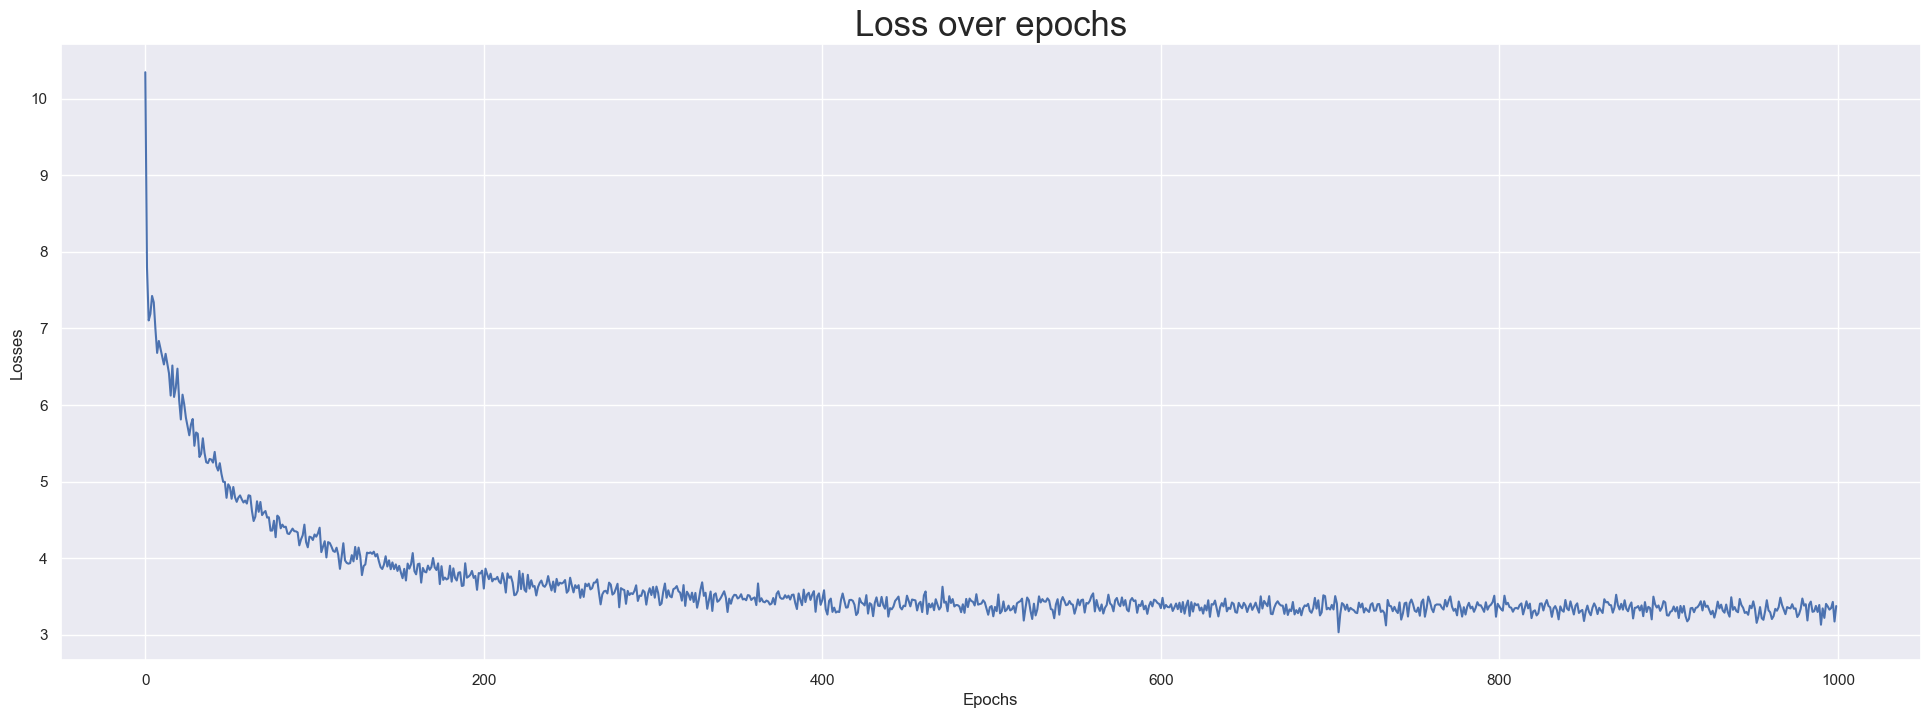

In [377]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.figure(figsize=(24,8))
plt.plot([i.item() for i in losses])
plt.title('Loss over epochs', fontsize=25)
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.show()

In [380]:
torch.manual_seed(6545554)
inp = encode('What is Machine Learning ?')
#print(m.generate(torch.tensor([inp], dtype=torch.long), 10).tolist())
output = decode(m.generate(torch.tensor([inp], dtype=torch.long), 100)[0].tolist())
print('INPUT')
print(inp)
print('OUTPUT')
print(output)

INPUT
[24589, 4926, 9001, 8758, 15251]
OUTPUT
What is Machine Learning ? ? ? ? ? Figure 3.5 Figure 6.6: Various information-theoretic measures have well try again. j−1)N+1 oil Type II [Cheeseman, et al., “AutoClass: import matplotlib import matplotlib import matplotlib import matplotlib import matplotlib import make_friedman1 ( datasets naive_bayes import train_test_split def RELU(z,l): # basic implementation BoostingRounds = datasets import matplotlib import svd , survey paper see: Fayyad, U., et al., 1972] Fikes, R., “Single Stage Threshold Logic, PhD Dissertation, Princeton University, Princeton, NJ, 1962. [Wnek, et al., “Comparing autograd import ECDF n , yy , XN are actually 2.82 · ∂S(X | 2)p(x2 | 1)p(x2 | 1)p(x2 | 2)p(2) or
